# Triangulate data from multiple Sleap networks

(latest version on Github at https://github.com/tytell/tytell-lab.git)
This file from commit $Id$

Requires `sleap` (https://sleap.ai/index.html) and `aniposelib` (version 0.6.1 or higher). Follow the directions to set up Sleap. Then  install `aniposelib` in the same python environment as Sleap: 
> % conda activate sleap

> % python -m pip install aniposelib

# Load in the Sleap data files

In [233]:
from sleap.io.dataset import Labels
import os
import re
import aniposelib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from copy import copy

In [234]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [235]:
import triangulate_sleap

Load the calibration we did above. Make sure the file name is correct!

In [236]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

Fill in the names of your cameras and the names of the Sleap `.slp` data files. You should have the same number of Sleap files as you do cameras. But if you trained the same network for multiple views, just repeat the name of the `.slp` file.

Note that the videos need to have matching names across the cameras. So you should have something like:
* test1_camA.mp4, test1_camB.mp4, test1_camC.mp4

or

* camA_test1.mp4, camB_test1.mp4, camC_test1.mp4

or something like that.

In [237]:
camnames = ["camA", "camB", "camC"]

sleapfiles = ['/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedLateral.slp',
              '/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedLateral.slp',
              '/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/PumpkinseedVentral.slp']

This will load in the Sleap points and the calibration. You can restrict to a certain number of videos using the `match_video` option, which uses usual file matching syntax (`*` matches anything, so `'*11.15.23*'` will match any videos that have 11.15.23 in the name)

In [238]:
camgroup, ptsall = triangulate_sleap.load_sleap_points(sleapfiles, 'calibration.toml', match_video='*11.15.23*')

/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py:231: UserWarning: Video D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/.98Vcon-11.15.23_Trial20_0RampcamC.mp4 in Sleap file multiple times
  warn(f'Video {v1name} in Sleap file multiple times')
/Users/etytel01/Documents/2023/tytell-lab-code/triangulate_sleap.py:231: UserWarning: Video D:/Stephen Acceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos/1V-11.15.23_Trial9_1.4RampcamC.mp4 in Sleap file multiple times
  warn(f'Video {v1name} in Sleap file multiple times')


Found 42675 frames across 4 matched videos


Then this triangulates the points and computes the reprojections.

In [239]:
ptsall3d = triangulate_sleap.triangulate_points(camgroup, ptsall)



## Checking reprojections


100%|█████████████████████████| 42675/42675 [00:11<00:00, 3690.18it/s]


Finally, you can check the reprojections by plotting them. This will show the camera views, with red points representing the original tracked points, yellow crosses for the reprojected points, and yellow lines connecting the same point.

frame == 113 and video == "1V-11.15.23_Trial9_1.4RampCAMERA.mp4"


/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_30156/2466124920.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


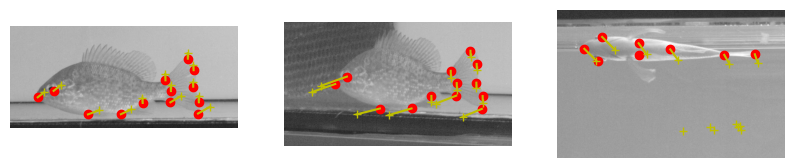

In [240]:
fig = triangulate_sleap.plot_reprojected_points(ptsall3d, 20000, 
                                          videopath='/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos',
                                          zoom=True)
fig.show()


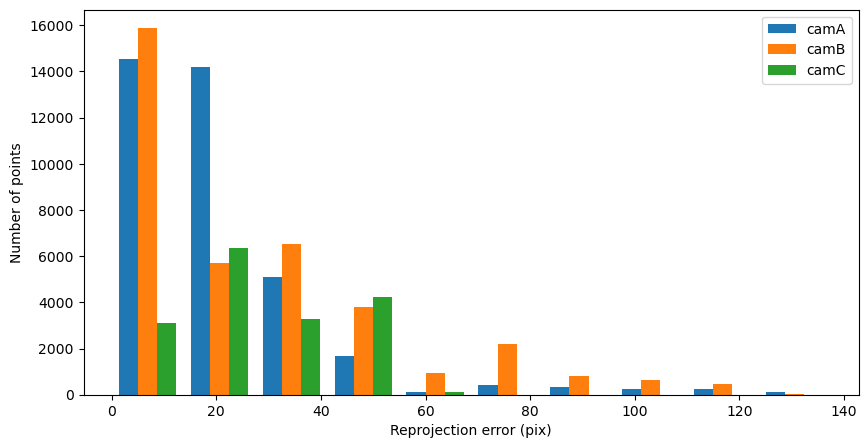

In [244]:
plt.hist(ptsall3d.loc[:,(slice(None),'err')])
plt.legend(camgroup.get_names())
plt.xlabel('Reprojection error (pix)')
plt.ylabel('Number of points')
plt.show()

In [245]:
ptsall3d.index.get_level_values(2).unique()

Index(['Snout', 'Left_eye', 'Right_eye', 'Left_pelvic', 'Right_pelvic', 'Anus',
       'Peduncle_dorsal', 'Peduncle_middle', 'Peduncle_ventral',
       'Caudal_dorsal_tip', 'Caudal_dorsal_lobe', 'Caudal_middle',
       'Caudal_ventral_lobe', 'Caudal_ventral_tip', 'Anal_insertion'],
      dtype='object', name='node')

In [250]:
camgroup1 = triangulate_sleap.refine_calibration(camgroup, ptsall3d, 40) #, ['Snout','Left_eye', 'Anus', 'Caudal_ventral_tip'])

17068/42675 points visible in all cameras
8271/42675 (19%) points below maximum error
error:  20.39012437752929
n_samples: 200
{(0, 1): (2648, array([16.05229688, 28.23784607])),
 (0, 2): (2648, array([15.68725439, 21.21097494])),
 (1, 2): (2648, array([12.29524358, 25.24197641]))}
error: 20.42, mu: 16.1, ratio: 0.206
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3813e+05                                    3.77e+07    
       1              2         5.3835e+03      1.33e+05       9.83e+02       1.67e+06    
       2              4         4.5875e+03      7.96e+02       6.15e+02       1.03e+06    
       3              5         4.0314e+03      5.56e+02       1.02e+02       5.86e+04    
       4              7         4.0264e+03      5.00e+00       1.46e+02       2.62e+04    
       5              9         4.0238e+03      2.57e+00       7.20e+01       1.34e+04    
       6             10         4.0201e+03 

In [251]:
ptsall3d2 = triangulate_sleap.triangulate_points(camgroup1, ptsall)



## Checking reprojections


100%|█████████████████████████| 42675/42675 [00:11<00:00, 3790.00it/s]


frame == 113 and video == "1V-11.15.23_Trial9_1.4RampCAMERA.mp4"


/var/folders/rs/r2xck00j2td2g2w0g6s_t2lx370bnk/T/ipykernel_30156/2415620306.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


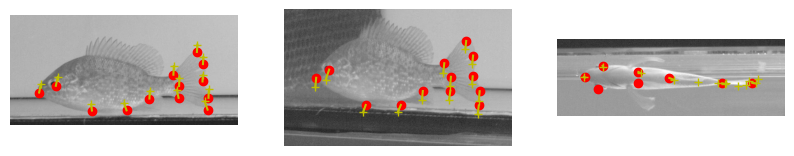

In [252]:
fig = triangulate_sleap.plot_reprojected_points(ptsall3d2, 20000, 
                                          videopath='/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Videos',
                                          zoom=True)
fig.show()


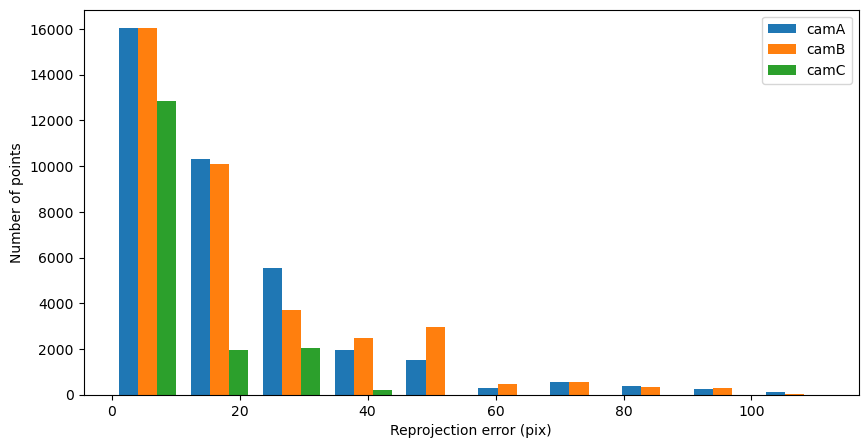

In [253]:
plt.hist(ptsall3d2.loc[:,(slice(None),'err')])
plt.legend(camgroup.get_names())
plt.xlabel('Reprojection error (pix)')
plt.ylabel('Number of points')
plt.show()

These are the median reprojection errors. Make sure they're not too big.

In [254]:
ptsall3d2.loc[:,(slice(None), 'err')].groupby(level=2).median()

camera,camA,camB,camC
var,err,err,err
node,,,
Anal_insertion,13.065269,13.419758,NaN
Anus,12.539647,12.610391,7.237692
Caudal_dorsal_lobe,14.535717,14.992273,NaN
Caudal_dorsal_tip,12.770013,13.239975,NaN
Caudal_middle,13.704490,14.129877,NaN
Caudal_ventral_lobe,13.178323,13.622368,NaN
Caudal_ventral_tip,14.328498,13.510404,4.762586
Left_eye,14.945840,15.539495,3.887926


Then we merge all of the data frames so that we have the 2D x and y coordinates and the 3D coordinates with reprojection errors.

In [255]:
ptsall3d2.head()

camera                                                          camA  \
var                                                                x   
video                                frame node                        
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         1243.096309   
                                           Left_eye      1268.688036   
                                           Right_eye             NaN   
                                           Left_pelvic   1338.631047   
                                           Right_pelvic          NaN   

camera                                                               \
var                                                               y   
video                                frame node                       
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         571.946166   
                                           Left_eye      551.738507   
                                           Right_eye            NaN   
                                           Left_pelvic   594.236171   
                                           Right_pelvic         NaN   

camera                                                          camB  \
var                                                                x   
video                                frame node                        
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         1169.338538   
                                           Left_eye      1191.585528   
                                           Right_eye             NaN   
                                           Left_pelvic   1276.323979   
                                           Right_pelvic          NaN   

camera                                                               \
var                                                               y   
video                                frame node                       
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout          665.92632   
                                           Left_eye      646.189286   
                                           Right_eye            NaN   
                                           Left_pelvic   694.770316   
                                           Right_pelvic         NaN   

camera                                                          camC  \
var                                                                x   
video                                frame node                        
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         1505.471619   
                                           Left_eye      1534.239747   
                                           Right_eye     1534.749842   
                                           Left_pelvic   1618.115309   
                                           Right_pelvic  1617.768282   

camera                                                               \
var                                                               y   
video                                frame node                       
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         154.143312   
                                           Left_eye      131.362774   
                                           Right_eye     175.599816   
                                           Left_pelvic   146.032301   
                                           Right_pelvic  161.292322   

camera                                                          3D             \
var                                                              x          y   
video                                frame node                                 
.2V-11.15.23_Trial1_.2RampCAMERA.mp4 0     Snout         75.623627  74.138335   
                                           Left_eye      79.650971  69.533687   
                                           Right_eye           NaN        NaN   
                                           Left_pelvic   92.386632  74.19963

In [256]:
ptsall3dflat = copy(ptsall3d2)
ptsall3dflat.columns = ['_'.join(reversed(c)) for c in ptsall3dflat.columns.to_flat_index()]
ptsall3dflat.reset_index(inplace=True)
ptsall3dflat.head()

,video,frame,node,x_camA,y_camA,x_camB,y_camB,x_camC,y_camC,x_3D,...,z_3D,Xr_camA,Yr_camA,Xr_camB,Yr_camB,Xr_camC,Yr_camC,err_camA,err_camB,err_camC
0,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Snout,1243.096309,571.946166,1169.338538,665.92632,1505.471619,154.143312,75.623627,...,1839.609535,1240.057097,570.651252,1169.829640,666.446391,1508.583126,153.634521,3.303576,0.715301,3.152831
1,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Left_eye,1268.688036,551.738507,1191.585528,646.189286,1534.239747,131.362774,79.650971,...,1834.409815,1269.409521,551.935903,1191.717928,646.242711,1533.246950,131.438593,0.748001,0.142772,0.995687
2,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Right_eye,NaN,NaN,NaN,NaN,1534.749842,175.599816,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Left_pelvic,1338.631047,594.236171,1276.323979,694.770316,1618.115309,146.032301,92.386632,...,1839.040156,1337.483420,592.311810,1273.703410,695.937921,1622.144330,146.238530,2.240584,2.868917,4.034295
4,.2V-11.15.23_Trial1_.2RampCAMERA.mp4,0,Right_pelvic,NaN,NaN,NaN,NaN,1617.768282,161.292322,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


And save! Remember to adjust the file name as needed.

In [99]:
ptsall3dflat.to_csv('points3d.csv', index=False)